<a href="https://colab.research.google.com/github/Blacksujit/Intent-Detection/blob/main/first_approach_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Trained Model Approach


# Install Necessary Libraries




In [26]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import string
import spacy
# import spacy_fastlang
# import spacy_langdetect
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

# Load Pretrained Model


In [9]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Load the dataset

In [12]:
df = pd.read_csv('/content/sofmattress_train.csv')

In [21]:
# Clean the text

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df['sentence'] = df['sentence'].apply(clean_text)

# Drop rows with missing values
df.dropna(subset=['sentence', 'label'], inplace=True)

In [28]:
# Label Encoding


# Encode intent labels
label_encoder = LabelEncoder()
df['sentence'] = label_encoder.fit_transform(df['sentence'])

# Save the mapping of labels for future use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label Mapping: {label_mapping}")

Label Mapping: {'': 0, 'about sof mattress': 1, 'almost month over': 2, 'any discounts': 3, 'any shop that i can visit': 4, 'are pillows available': 5, 'arrange a call back': 6, 'available offers': 7, 'back ache issue': 8, 'back pain': 9, 'call me now': 10, 'can i also have pillows': 11, 'can i buy pillows from here': 12, 'can i cancel my order here': 13, 'can i do cod': 14, 'can i get cod option': 15, 'can i get delivery on this pincode': 16, 'can i get free trial': 17, 'can i get pillows': 18, 'can i please have the size chart': 19, 'can i try a mattress first': 20, 'can i visit sof mattress showroom': 21, 'can it deliver by cod': 22, 'can mattress size be customised': 23, 'can pay later on delivery': 24, 'can we buy through paisa finance': 25, 'can you deliver on my pincode': 26, 'can you give me night trial': 27, 'can you help with the size': 28, 'can you make delivery on this pin code': 29, 'can you please deliver on my pincode': 30, 'cancel my order': 31, 'cancel order': 32, 'can

In [32]:
# Tokenization

# Tokenization function
def tokenize_data(text_list, tokenizer, max_length=128):
    """
    Tokenizes a list of text inputs and converts them to BERT-compatible tensors.
    """
    return tokenizer(
        text_list,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize the label column
tokenized_data = tokenize_data(df['label'].tolist(), tokenizer)

In [33]:
# Create a PyTorch Dataset

In [34]:
import torch
from torch.utils.data import Dataset

class IntentDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        self.input_ids = tokenized_data['input_ids']
        self.attention_mask = tokenized_data['attention_mask']
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Create a PyTorch dataset
intent_dataset = IntentDataset(
    tokenized_data,
    df['sentence'].tolist()
)

In [38]:
# Split the Data

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['label'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize again for the split datasets
train_data = tokenize_data(train_texts, tokenizer)
val_data = tokenize_data(val_texts, tokenizer)

# Create PyTorch datasets
train_dataset = IntentDataset(train_data, train_labels)
val_dataset = IntentDataset(val_data, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

ValueError: too many dimensions 'str'

In [40]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
class IntentDetectionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Custom PyTorch Dataset for Intent Detection

        Args:
            texts (list): Input sentences
            labels (list): Corresponding labels
            tokenizer (AutoTokenizer): Pretrained tokenizer
            max_length (int): Maximum sequence length
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Tokenize and prepare single item

        Returns:
            Tokenized input and label
        """
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [43]:
class IntentDetectionModel:
    def __init__(self, dataset_path, model_name='distilbert-base-uncased'):
        """
        Initialize Intent Detection Pipeline

        Args:
            dataset_path (str): Path to training dataset
            model_name (str): Pretrained model name
        """
        # Load and preprocess data
        self.df = pd.read_csv(dataset_path)

        # Label Encoding
        self.label_encoder = LabelEncoder()

        # Pretrained model and tokenizer
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def preprocess_data(self):
        """
        Preprocess dataset

        Returns:
            Cleaned and encoded dataset
        """
        # Remove duplicates
        self.df.drop_duplicates(subset=['sentence'], inplace=True)

        # Clean text
        self.df['cleaned_text'] = self.df['sentence'].str.lower().str.strip()

        # Encode labels
        self.df['encoded_label'] = self.label_encoder.fit_transform(self.df['label'])

        return self.df

    def prepare_data_loaders(self, test_size=0.2, batch_size=16):
        """
        Prepare train and validation data loaders

        Args:
            test_size (float): Proportion of test set
            batch_size (int): Batch size for training

        Returns:
            Train and validation data loaders
        """
        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            self.df['cleaned_text'],
            self.df['encoded_label'],
            test_size=test_size,
            stratify=self.df['encoded_label'],
            random_state=42
        )

        # Create datasets
        train_dataset = IntentDetectionDataset(
            X_train.values,
            y_train.values,
            self.tokenizer
        )
        val_dataset = IntentDetectionDataset(
            X_val.values,
            y_val.values,
            self.tokenizer
        )

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        return train_loader, val_loader, X_val, y_val

    def create_model(self):
        """
        Create pretrained sequence classification model

        Returns:
            Configured model for intent detection
        """
        model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=len(self.label_encoder.classes_)
        )

        return model.to(self.device)

    def train_model(self, model, train_loader, val_loader, epochs=5):
        """
        Train the intent detection model

        Args:
            model (AutoModelForSequenceClassification): Pretrained model
            train_loader (DataLoader): Training data loader
            val_loader (DataLoader): Validation data loader
            epochs (int): Number of training epochs

        Returns:
            Trained model
        """
        # Optimizer
        optimizer = AdamW(
            model.parameters(),
            lr=2e-5,
            eps=1e-8
        )

        # Learning rate scheduler
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Training loop
        model.train()
        for epoch in range(epochs):
            total_train_loss = 0

            for batch in train_loader:
                # Prepare batch
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Zero gradients
                model.zero_grad()

                # Forward pass
                outputs = model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_train_loss += loss.item()

                # Backward pass
                loss.backward()

                # Clip gradient norms
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters
                optimizer.step()
                scheduler.step()

            # Print epoch summary
            avg_train_loss = total_train_loss / len(train_loader)
            print(f'Epoch {epoch+1}/{epochs}')
            print(f'Average training loss: {avg_train_loss:.4f}')

        return model

    def evaluate_model(self, model, val_loader, X_val, y_val):
        """
        Evaluate model performance

        Args:
            model (AutoModelForSequenceClassification): Trained model
            val_loader (DataLoader): Validation data loader
            X_val (array): Validation text data
            y_val (array): Validation labels

        Returns:
            Evaluation metrics
        """
        model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = model(
                    input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Classification Report
        print("Classification Report:")
        print(classification_report(
            true_labels,
            predictions,
            target_names=self.label_encoder.classes_
        ))

        # Confusion Matrix
        cm = confusion_matrix(true_labels, predictions)
        self.plot_confusion_matrix(cm, self.label_encoder.classes_)

        return {
            'accuracy': accuracy_score(true_labels, predictions),
            'classification_report': classification_report(
                true_labels,
                predictions,
                target_names=self.label_encoder.classes_,
                output_dict=True
            )
        }

    def plot_confusion_matrix(self, cm, class_names):
        """
        Visualize confusion matrix

        Args:
            cm (array): Confusion matrix
            class_names (array): Class labels
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

In [44]:
def main():
    # Initialize the intent detection pipeline
    intent_detector = IntentDetectionModel('sofmattress_train.csv')

    # Preprocess data
    preprocessed_df = intent_detector.preprocess_data()

    # Prepare data loaders
    train_loader, val_loader, X_val, y_val = intent_detector.prepare_data_loaders()

    # Create model
    model = intent_detector.create_model()

    # Train model
    trained_model = intent_detector.train_model(model, train_loader, val_loader)

    # Evaluate model
    evaluation_results = intent_detector.evaluate_model(
        trained_model,
        val_loader,
        X_val,
        y_val
    )

    print("\nModel Evaluation Results:")
    print(f"Accuracy: {evaluation_results['accuracy']:.4f}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Average training loss: 3.0361
Epoch 2/5
Average training loss: 2.9448
Epoch 3/5
Average training loss: 2.8047
Epoch 4/5
Average training loss: 2.7378
Epoch 5/5
Average training loss: 2.6610
Classification Report:
                       precision    recall  f1-score   support

100_NIGHT_TRIAL_OFFER       1.00      0.25      0.40         4
   ABOUT_SOF_MATTRESS       1.00      0.50      0.67         2
         CANCEL_ORDER       0.00      0.00      0.00         2
        CHECK_PINCODE       0.00      0.00      0.00         2
                  COD       0.00      0.00      0.00         2
           COMPARISON       0.00      0.00      0.00         2
    DELAY_IN_DELIVERY       0.00      0.00      0.00         2
         DISTRIBUTORS       0.22      1.00      0.36         7
                  EMI       0.50      0.60      0.55         5
        ERGO_FEATURES       0.00      0.00      0.00         2
             LEAD_GEN       0.43      0.75      0.55         4
        MATTRESS_COS

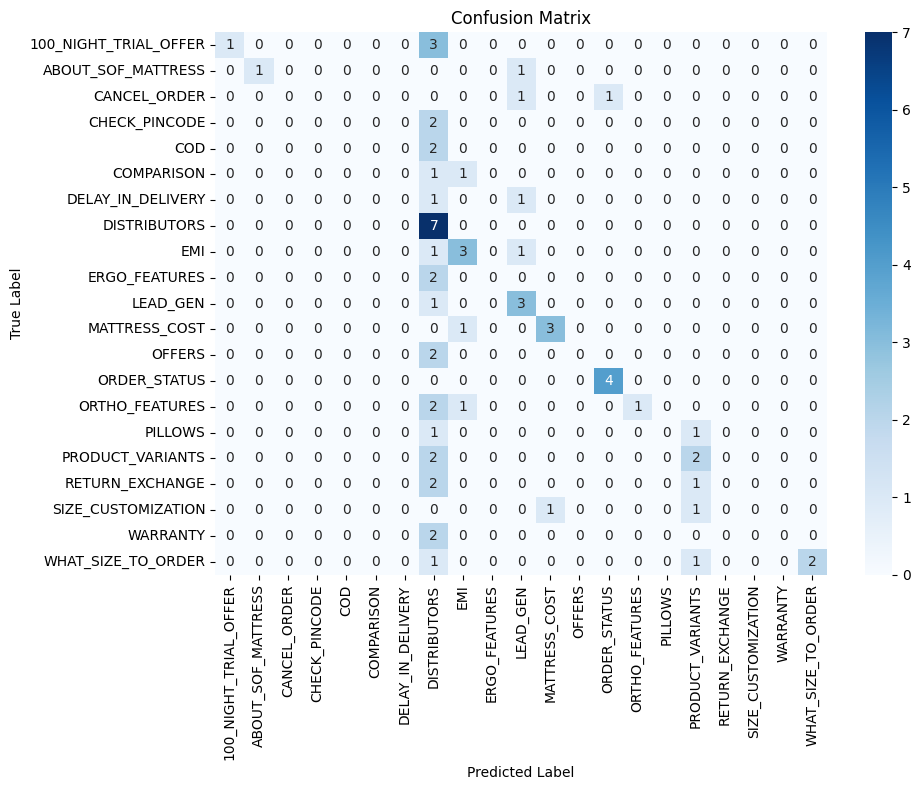


Model Evaluation Results:
Accuracy: 0.4154


In [45]:
if __name__ == "__main__":
    main()